In [1]:
import ROOT, rat
import os, sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
sys.path.append('/home/jp/projects/python_tools')
import jp_mpl as jplot
import rat
from itertools import cycle


TClass::TClass:0: RuntimeWarning: no dictionary for class omtext is available


In [2]:
gaus = lambda x, normalization, mean, sigma: normalization * np.exp(-0.5 * (x - mean)**2 / sigma**2)
two_gaus = lambda x, n1, m1, s1, n2, m2, s2: gaus(x, n1, m1, s1) + gaus(x, n2, m2, s2)
from scipy import optimize

def getNorm(v):
    return v/np.sqrt(np.sum(v**2))
def renormN(n, axis=0):
    n+= 1E-9

    integral = np.sum(n,axis=axis)
    if axis==0:
        return n/integral
    else:
        return (n.T/integral).T

In [3]:
infile_dir = '/home/jp/projects/snoplus/rundir/greydisc_validation/onepmt_greydiscON'


In [4]:
infile_name = 'thebox.root'

In [5]:
try:
    ratreader.close()
    print 'Closing file before reopenning'
except:
    print 'No ratreader file. Opening it for the first time'
fname = os.path.join(infile_dir, infile_name)
if os.path.isfile(fname): print 'File exists'
ratreader = rat.dsreader(fname)

No ratreader file. Opening it for the first time
File exists


In [6]:
def doRead(single = False):
    photons_steps = [] # List of tracks
    photons_p     = []
    photons_ids   = []
    volumes       = []
    process       = []
    for ds, run in ratreader:
        mymc = ds.GetMC()
        for itrack in range(1, mymc.GetMCTrackCount()+1):
            mytrack = mymc.GetMCTrack(itrack)
            
            # End here to study the info in a track
            if single:
                return mytrack
            
            volumes.append([])
            process.append([])
            photons_steps.append(np.zeros(3))
            photons_p.append(np.zeros(3))
            
            photons_ids.append(mytrack.GetTrackID())
            
            #if pdg_code != 22: 
            #    # Particle is not a gamma
            #    continue
            
            for istep in range(mymc.GetMCTrack(itrack).GetMCTrackStepCount()):
                photons_steps[-1] = np.vstack((photons_steps[-1], np.zeros(3)))
                photons_p[-1] = np.vstack((photons_p[-1], np.zeros(3)))

                mystep = mymc.GetMCTrack(itrack).GetMCTrackStep(istep)
                position = mystep.GetPosition()
                momentum = mystep.GetMomentum()
                position.GetXYZ(photons_steps[-1][-1,:])
                momentum.GetXYZ(photons_p[-1][-1,:])
                process[-1].append(mystep.GetProcess())
                volumes[-1].append(mystep.GetEndVolume())

                
    ratreader.close()
    
    hcvalue = 1.239841 # eV*um (electronvolts times micrometer)
    
    return photons_steps, photons_p, volumes, \
           process, np.array(photons_ids)

In [7]:
one_track = doRead(single=True)

In [8]:
try:
    ratreader.close()
    print 'Closing file before reopenning'
except:
    print 'No ratreader file. Opening it for the first time'
fname = os.path.join(infile_dir, infile_name)
if os.path.isfile(fname): print 'File exists'
ratreader = rat.dsreader(fname)

Closing file before reopenning
File exists


In [9]:
pos, mom, volumes,proc, ids = doRead()

### Need only those that are reflected from the PMT ... so I need at least 2 steps, right?

In [10]:
print 'Following a photon'
index = 250
print 'Position'
print pos[index]
print 'Momentum'
print mom[index]
print 'End volume'
print volumes[index]
print 'Processes'
print proc[index]
print 'Track ID'
print ids[index]


Following a photon
Position
[[    0.             0.             0.        ]
 [   61.          -119.19255829    96.79275513]
 [   59.          -122.96282959    94.7420578 ]
 [ -406.23828125 -1000.          -382.28845215]]
Momentum
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.04751712e-06  -1.97471149e-06  -1.07406811e-06]
 [ -1.04751712e-06  -1.97471149e-06  -1.07406811e-06]
 [ -1.04751712e-06  -1.97471149e-06  -1.07406811e-06]]
End volume
['planewave', 'world', 'NULL']
Processes
['Unknown', 'Transportation', 'Transportation']
Track ID
1


In [11]:
# The particles that end up in NULL made it out of the PMT
# If the momentum in x in the second step is negative it goes away from the PMT
# Positive momentum goes towards the PMT -- done

# I put the zeros there myself, dont look at them
# If the length of end volume or processes is 2, then the particle wasnt reflected
# If the last volume is the 'r_1408_pmt' then the particle as absorbed
# Gotta be careful with reflections from the outside of the PMT volume ... 
# These reflections wouldn't be a problem if I could put a cylindrical cap instead of the box
# Easy fix: only take photons that are emitted within the radius of the concentrator (see gdisc radius)
# Last momentum needs to have negative x
# End volume needs to be NULL
# Re-run with a smaller world to avoid scattering in the water ... also, change to heavy water

In [12]:
good_pos = []
good_mom = []
all_volumes = []
all_proc = []
gdisc_radius = 137.7
for iPhoton in range(len(pos)):
    
    # Only use photons produced on the side of my volume looking at the PMT
    # This won't change the conclusions of the study (material doesn't change)
    # but it matters for the first reflection study
    if pos[iPhoton][1][0] < 60.5:
        continue
    
    # Look at px of step 1 (step 0 is zero by construction) - only take positives
    if mom[iPhoton][1][0] < 0:
        continue

    # Last step needs to be going outwards
    if mom[iPhoton][-1][0] > 0:
        continue

    # Calculate the radius at emission point, only take those starting within the gdisc radius 
    r = np.sqrt(np.sum(pos[iPhoton][1][1:]**2))
    if r > gdisc_radius:
        continue
        
    if volumes[iPhoton][-1] != 'NULL':
        continue
        
    # Keep all these photons
    # I could do my operations here, but I'll store them for now
    good_pos.append(pos[iPhoton])
    good_mom.append(mom[iPhoton])
    all_volumes.append(volumes[iPhoton])
    all_proc.append(proc[iPhoton])

In [13]:
i =379
print good_pos[i]
print good_mom[i]

[[    0.             0.             0.        ]
 [   61.           -27.67610359     4.64361   ]
 [   62.20000076   -27.02384186     5.83188915]
 [   62.1980896    -29.10103607    -3.67985392]
 [   62.1980896    -29.10103607    -3.67985392]
 [   61.           -30.08831024    -6.40552855]
 [   59.           -31.73639107   -10.95556068]
 [ -375.74169922  -389.98117065 -1000.        ]]
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.64385960e-06   8.93521985e-07   1.62780339e-06]
 [  1.64385960e-06   8.93521985e-07   1.62780339e-06]
 [ -9.47231513e-07  -7.80557116e-07  -2.15496698e-06]
 [ -9.47231513e-07  -7.80557116e-07  -2.15496698e-06]
 [ -9.47231513e-07  -7.80557116e-07  -2.15496698e-06]
 [ -9.47231513e-07  -7.80557116e-07  -2.15496698e-06]
 [ -9.47231513e-07  -7.80557116e-07  -2.15496698e-06]]


In [14]:
# Contents of the output dictionary
# Recall the PMT rotational symmetry is around the x-axis
# y - starting position in y (front, back)
# z - starting position in z (up, down)
# xr - position (xyz) of the reflection 
# momentum - incoming momentum vector
# theta_i
# phi_i
# theta_f
# phi_f


keys = ['y','z', 'xr', 'theta_i', 'phi_i','theta_f','phi_f','momentum',]
data = {}
for iKey in keys:
    if iKey != 'momentum':
        data[iKey] = np.zeros(len(good_pos))
data['momentum'] = np.zeros([len(good_pos), 3])
data['xr']       = np.zeros([len(good_pos), 3])


normal = np.array([-1, 0, 0])

stop_at = -1

for iPhoton in range(len(good_pos)):
    data['y'][iPhoton] = good_pos[iPhoton][1][1]
    data['z'][iPhoton] = good_pos[iPhoton][1][2]
    
    # Because I'm looking at the reflection, the x should come from the *second* step
    # Remember, step 0 is nothing, 1 is the first position, 2 is the reflection (starting point)
    
    # I have to look at the 3rd position because the 2nd one seems to be still an effect of the surface
    data['xr'][iPhoton,:] = good_pos[iPhoton][3][:]
    #for one_step in range(good_pos[iPhoton].shape[0]):
    #    if data['xr'][iPhoton,0] < good_pos[iPhoton][one_step][0]:
    #        data['xr'][iPhoton,:] = good_pos[iPhoton][one_step][:]

    data['momentum'][iPhoton,:] = good_mom[iPhoton][1][:]
    
    # The negative value is because the theta is negative - otherwise I would need to correct for it later
    data['theta_i'][iPhoton] = np.arccos(np.dot(normal, -getNorm(good_mom[iPhoton][1])))
    
    # The phi is obtained 
    data['phi_i'][iPhoton]   = np.arctan2(good_mom[iPhoton][1][2],
                               good_mom[iPhoton][1][1])
    
    data['theta_f'][iPhoton] = np.arccos(np.dot(normal, getNorm(good_mom[iPhoton][-1])))
    
    # This is not correct, should be momentum
    data['phi_f'][iPhoton]   = np.arctan2(good_mom[iPhoton][-1][2], 
                                   good_mom[iPhoton][-1][1])
    
    if iPhoton % 10000 == 0:
        print iPhoton
        
    if iPhoton == stop_at:
        print 'Momentum'
        print good_mom[iPhoton]
        print 'Position'
        print good_pos[iPhoton]
        break

0
10000
20000
30000
40000
50000
60000
70000


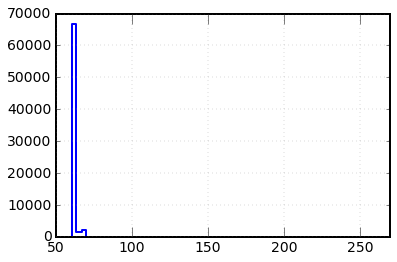

In [15]:
xarray = np.linspace(50, 270, 101)
b, x = np.histogram(data['xr'][:,0], xarray)
jplot.unfilledBar(x,b)

20413


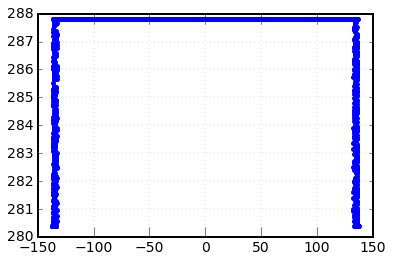

In [16]:
yz_center = 0
tol = 30 # mm
ybool = (data['xr'][:,1] > (yz_center-tol) )*(data['xr'][:,1]< (yz_center+tol) )
print np.sum(ybool)
plt.plot(data['xr'][ybool,2], 350-data['xr'][ybool,0], '.')

In [17]:
data['r'] = np.sqrt(data['y']**2 + data['z']**2)
phidiff = (data['phi_f'] - data['phi_i'])
phidiff[phidiff<0] += np.pi*2
data['phidiff'] = phidiff

In [18]:
# Verifying PhiDiff (and the meaning of 180 degrees)

In [19]:
phi_reflect = (data['phidiff'] - np.pi) < 0.2
phi_reflect
#np.rad2deg(data['phidiff'][phi_reflect][0])

array([False, False, False, ..., False, False,  True], dtype=bool)

In [20]:
len(mom)
print len(data['phidiff'])

71866


In [21]:
import pickle
pickle.dump(data, open('/home/jp/projects/snoplus/rundir/greydisc_validation/onepmt_greydiscON/condensed.pckl','w'))